In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [3]:
plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (cm2inch(19),cm2inch(9))
#plotsize_subplots = (16,3)

fontsize_axis = 7
fontsize_labels = 7
fontsize_legends = 4

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

## Functions

In [4]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_vp"""
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():  # Population model
        # Population model does not simulate, VSize_mem is therefore equal to VSize_ini_sum as this is the
        # end of the benchmark
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df):  # MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']  # VSize_mem_sum is called VSize_net_sum for MAM
        df['VSize_nodes_sum'] = np.NaN  # MAM model does not have VSize_nodes_sum

    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)

    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per VP'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3

    return df

In [5]:
def time_and_memory_per_connection(df):
    df = time_per_connection(df)
    df = memory_per_connection(df)
    return df

In [6]:
def time_per_connection(df):
    df['Total Conn. Time per Conn.'] = df['Conn. Total']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Creation Time \n per Conn. (min)'] = df['Conn. Creation (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Exchange Time \n per Conn. (min)'] = df['Conn. Exchange (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    return df

In [7]:
def memory_per_connection(df):
    df['Memory per connection'] = (df['VSize_ini_sum'] - df['VSize_nodes_sum']) / df['N_conns_sum'] * 1024
    df['Total Mem. per Conn.'] = df['VSize_mem_sum'] / df['N_conns_sum'] * 1024
    return df

In [8]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45, one_row=True, logy=False,
                 color=None, plot_T_sim=True, plot_kind='bar'):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per VP']
    if not index:
        index='N_VP'
    if plot_T_sim:
        df['Simulation time'] = df['T_sim']
        values.insert(3, 'Simulation time')
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)

    # Make subplots
    if one_row:
        fig, axes = plt.subplots(nrows=1, ncols=len(values))
        if len(values) == 1:
            axes = [axes]
                
        for indx, val_name in enumerate(values):
            df_p[val_name].plot(kind=plot_kind, ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot,
                                logy=logy, legend=False, color=color)
        axes[0].legend(fontsize=fontsize_legends, loc=legend_loc)
        
        plt.subplots_adjust(wspace=0.5)
    else:
        plotsize_subplots = (cm2inch(19),cm2inch(9))
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=plotsize_subplots)

        df_p['Conn. Creation (min)'].plot(kind='bar', ax = axes[0][0], title='Conn. Creation (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        axes[0][0].legend(fontsize=fontsize_legends, loc=legend_loc)
        df_p['Conn. Exchange (min)'].plot(kind='bar', ax = axes[0][1], title='Conn. Exchange (min)',
                                          fontsize=fontsize_axis, rot=rot, legend=False)
        df_p['Conn. Total'].plot(kind='bar', ax = axes[1][0], title='Conn. Total', fontsize=fontsize_axis,
                                 rot=rot, legend=False)
        df_p['Memory per VP'].plot(kind='bar', ax = axes[1][1], title='Memory per VP', fontsize=fontsize_axis,
                                   rot=rot, legend=False)

        plt.subplots_adjust(wspace=0.5, hspace=0.7)

    # y-axis labels
    if 'Total Conn. Time per Conn.' in values:  
        axes[0].set_ylabel(r'Time [$\mu$s]')  # Not safe..
    else:
        if one_row:
            axes[0].set_ylabel('Time [s]')
        else:
            axes[0][0].set_ylabel('Time [s]')
            axes[1][0].set_ylabel('Time [s]')
    if 'Memory per VP' in values:
        # Assume memory is last entry in values
        if one_row:
            axes[len(values) - 1].set_ylabel('Memory [GiB]')
        else:
            axes[1][1].set_ylabel('Memory [GiB]')
    elif 'Memory per connection' in values:
        axes[len(values) - 1].set_ylabel('Memory [B]')

    # x-axis labels
    if one_row:
        for ax in axes:
            ax.set_xlabel(index)

    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

## Benchmarks with weak scaling

### HPC Benchmark

Conn. Creation (min)                     Conn. Exchange (min)  \
Case    Master (6d8d3047) NEST 3.0 (3aae0a19)    Master (6d8d3047)   
N_VP                                                                 
36                  54.87               56.91                43.81   
72                  54.85               57.96                45.60   
144                 55.11               59.61                46.82   
288                 53.63               58.64                49.08   
576                 52.70               59.70                59.66   
1152                52.56               60.07                79.56   

                               Conn. Total                      \
Case NEST 3.0 (3aae0a19) Master (6d8d3047) NEST 3.0 (3aae0a19)   
N_VP                                                             
36                 42.52            106.98              105.86   
72                 43.92            105.84              106.86   
144                43.88            112.07              108.99   
288                47.14            111.14              113.16   
576                60.31            124.92              127.55   
1152               78.88            144.27              147.70   

         Memory per VP                       Simulation time  \
Case Master (6d8d3047) NEST 3.0 (3aae0a19) Master (6d8d3047)   
N_VP                                                           
36            2.818064            2.811359            200.10   
72            2.827462            2.812945            200.28   
144           2.905892            2.898536            208.25   
288           2.911404            2.904190            214.83   
576           3.028186            3.029565            232.99   
1152          3.379609            3.374423            267.95   

                          
Case NEST 3.0 (3aae0a19)  
N_VP                      
36                202.17  
72                204.42  
144               212.39  
288               220.78  
576               243.36  
1152              274.15

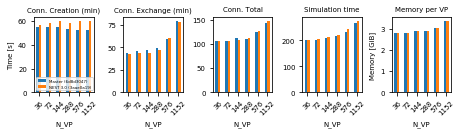

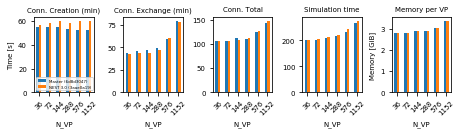

In [13]:
hpc_m = pd.read_csv('results/hpc_benchmark_6d8d3047_daint.csv')
hpc_m['Case'] = ['Master (6d8d3047)'] * len(hpc_m)
hpc_3 = pd.read_csv('results/hpc_benchmark_3_0_daint.csv')
hpc_3['Case'] = ['NEST 3.0 (3aae0a19)'] * len(hpc_m)

hpc = pd.concat([hpc_m, hpc_3])

hpc = calculate_T_conn_and_memory(hpc)
hpc_p = plot_compare(hpc, 'figures/hpc_benchmark_weak_scaling.pdf', legend_loc='lower left')
hpc_p = plot_compare(hpc, 'figures/hpc_benchmark_weak_scaling.svg', legend_loc='lower left')

hpc_p

### Population model

Conn. Creation (min)                     Conn. Exchange (min)  \
Case    Master (6d8d3047) NEST 3.0 (3aae0a19)    Master (6d8d3047)   
N_VP                                                                 
36              82.395484           68.268138            42.445847   
72             113.637962           79.953391            42.048199   
144            172.283743          101.281447            41.480264   
288            296.239668          144.080008            44.489922   
576            524.236601          234.326606            55.321616   
1152          1025.495776          410.311771            98.690875   

                               Conn. Total                      \
Case NEST 3.0 (3aae0a19) Master (6d8d3047) NEST 3.0 (3aae0a19)   
N_VP                                                             
36             40.569822        133.159433          118.835180   
72             41.674768        164.163398          133.365934   
144            41.287533        223.381136          155.097899   
288            44.608692        352.316512          202.078788   
576            54.913836        595.139644          303.827724   
1152           94.521306       1151.514961          526.687053   

         Memory per VP                      
Case Master (6d8d3047) NEST 3.0 (3aae0a19)  
N_VP                                        
36            3.417058            3.452939  
72            3.470728            3.558691  
144           3.604781            3.770051  
288           3.515858            3.551783  
576           3.606819            3.560275  
1152          3.588683            3.944877

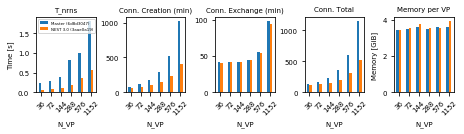

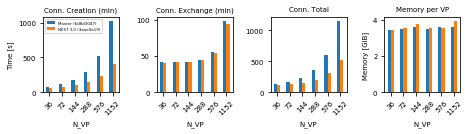

In [14]:
population_m = pd.read_csv('results/population_model_6d8d3047_daint_in.csv')
population_m['Case'] = ['Master (6d8d3047)'] * len(population_m)
population_3 = pd.read_csv('results/population_model_3_0_daint_in.csv')
population_3['Case'] = ['NEST 3.0 (3aae0a19)'] * len(population_m)

population = pd.concat([population_m, population_3])

population = calculate_T_conn_and_memory(population)
population_p = plot_compare(population, 'figures/population_model_weak_scaling.pdf',
                            ['T_nrns', 'Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total',
                             'Memory per VP'],
                            plot_T_sim=False, legend_loc='upper left')
population_p = plot_compare(population, 'figures/population_model_weak_scaling.svg',
                            plot_T_sim=False, legend_loc='upper left')

population_p

### Multi-Area Model

   NUMBER_OF_NODES  TASKS_PER_NODE  NUM_VPS  THREADS_PER_TASK   SCALE  \
0                1               6       36                 6  0.0625   
1                2               6       72                 6  0.1250   
2                4               6      144                 6  0.2500   
3                8               6      288                 6  0.5000   
4               16               6      576                 6  1.0000   
5               32               6     1152                 6  2.0000   
0                1               6       36                 6  0.0625   
1                2               6       72                 6  0.1250   
2                4               6      144                 6  0.2500   
3                8               6      288                 6  0.5000   
4               16               6      576                 6  1.0000   
5               32               6     1152                 6  2.0000   

   NUM_VPS.1  num_tasks  T_network_local  T_networ

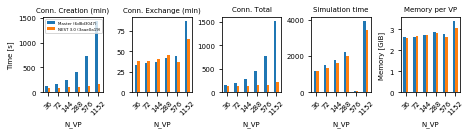

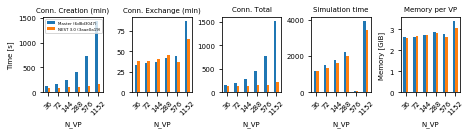

In [9]:
MAM_m = pd.read_csv('results/multi-area_model_6d8d3047_daint.csv')
MAM_m['Case'] = ['Master (6d8d3047)'] * len(MAM_m)
MAM_3 = pd.read_csv('results/multi-area_model_3_0_daint.csv')
MAM_3['Case'] = ['NEST 3.0 (3aae0a19)'] * len(MAM_m)

MAM = pd.concat([MAM_m, MAM_3])

MAM['T_conns_min'] = MAM['T_network_global_min'] + MAM['T_connect_min']
MAM['T_conns_max'] = MAM['T_network_global_max'] + MAM['T_connect_max']

MAM = calculate_T_conn_and_memory(MAM)
MAM_p = plot_compare(MAM, 'figures/multi-area_model_weak_scaling.pdf', legend_loc='upper left')
MAM_p = plot_compare(MAM, 'figures/multi-area_model_weak_scaling.svg', legend_loc='upper left')

print(MAM)
print(MAM['N_nrns'])
print(MAM['N_conns_sum'])

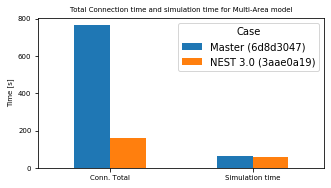

In [16]:
MAM_orig_m = pd.read_csv('results/multi-area_model_6d8d3047_daint_orig_n16.csv')
MAM_orig_m['Case'] = ['Master (6d8d3047)'] * len(MAM_orig_m)
MAM_orig_3 = pd.read_csv('results/multi-area_model_3_0_daint_orig_n16.csv')
MAM_orig_3['Case'] = ['NEST 3.0 (3aae0a19)'] * len(MAM_orig_3)

MAM_orig = pd.concat([MAM_orig_m, MAM_orig_3])

MAM_orig['T_conns_min'] = MAM_orig['T_network_global_min'] + MAM_orig['T_connect_min']
MAM_orig['T_conns_max'] = MAM_orig['T_network_global_max'] + MAM_orig['T_connect_max']
MAM_orig = calculate_T_conn_and_memory(MAM_orig)
MAM_orig['Simulation time'] = MAM_orig['T_sim']

values = ['Conn. Total', 'Simulation time']

df_p = pd.pivot_table(MAM_orig, columns='Case', values=values)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(cm2inch(13),cm2inch(7)))

df_p.plot(kind='bar', ax = axes, title='Total Connection time and simulation time for Multi-Area model',
          fontsize=fontsize_axis, rot=0)
axes.set_ylabel('Time [s]')

fig.savefig("figures/multi-area_model_original_size_Tconntotal_tsim.pdf", bbox_inches='tight')
fig.savefig("figures/multi-area_model_original_size_Tconntotal_tsim.svg", bbox_inches='tight')


### Topology model

NB! This is not 4x4!

,NUMBER_OF_NODES,TASKS_PER_NODE,THREADS_PER_TASK,num_tasks,NUM_VPS,SCALE,count,T_nrns,T_conns_max,T_conns_min,VSize_nodes_sum,VSize_mem_sum,VSize_ini_sum,VSize_sum,N_nrns,N_conns_sum,Case,N_VP
0,1,6,6,6,36,1,NaN,3.197931,133.165870,133.165381,7717088.0,45797600.0,NaN,NaN,661029.0,6.068004e+08,Master (6d8d3047),36
1,2,6,6,12,72,2,NaN,6.529109,296.823500,296.805448,17315184.0,148018544.0,NaN,NaN,1321997.0,2.422235e+09,Master (6d8d3047),72
2,4,6,6,24,144,4,NaN,12.224595,601.747579,601.704093,45746056.0,537835400.0,NaN,NaN,2643933.0,9.679000e+09,Master (6d8d3047),144
3,8,6,6,48,288,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Master (6d8d3047),288
0,1,6,6,6,36,1,NaN,9.264050,NaN,NaN,10528680.0,NaN,NaN,NaN,660968.0,NaN,NEST 3.0 (3aae0a19),36
1,2,6,6,12,72,2,NaN,34.223357,NaN,NaN,25238272.0,NaN,NaN,NaN,1321936.0,NaN,NEST 3.0 (3aae0a19),72
2,4,6,6,24,144,4,NaN,161.171360,NaN,NaN,73671080.0,NaN,NaN,NaN,2643872.0,NaN,NEST 3.0 (3aae0a19),144
3,8,6,6,48,288,8,NaN,677.169629,NaN,NaN,254890192.0,NaN,NaN,NaN,5287744.0,NaN,NEST 3.0 (3aae0a19),288


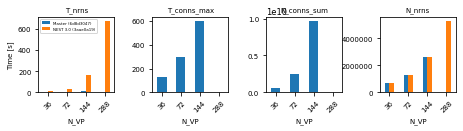

In [17]:
topology_m = pd.read_csv('results/topology_model_6d8d3047_daint.csv')
topology_m['Case'] = ['Master (6d8d3047)'] * len(topology_m)
topology_3 = pd.read_csv('results/topology_model_3_0_daint.csv')
topology_3['Case'] = ['NEST 3.0 (3aae0a19)'] * len(topology_3)

topology = pd.concat([topology_m, topology_3])

#topology = calculate_T_conn_and_memory(topology)

topology['N_VP'] = topology['NUM_VPS']

topology_p = plot_compare(topology, 'figures/topology_model_weak_scaling.pdf',
                          values=['T_nrns','T_conns_max', 'N_conns_sum', 'N_nrns'],
                          plot_T_sim=False, legend_loc='upper left')

topology

### 4x4 Mesocircuit model

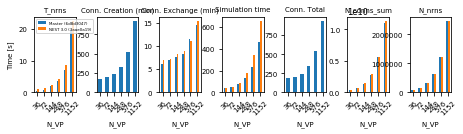

In [13]:
meso_m = pd.read_csv('results/4x4_mesocircuit_6d8d3047_daint.csv')
meso_m['Case'] = ['Master (6d8d3047)'] * len(meso_m)
meso_3 = pd.read_csv('results/4x4_mesocircuit_3_0_daint.csv')
meso_3['Case'] = ['NEST 3.0 (3aae0a19)'] * len(meso_3)

meso = pd.concat([meso_m, meso_3])

meso = calculate_T_conn_and_memory(meso)
meso
meso_p = plot_compare(meso, 'figures/4x4_mesocircuit_weak_scaling.pdf',
                      values=['T_nrns', 'Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'N_conns_sum', 'N_nrns'], legend_loc='upper left')

#print(meso['N_nrns'])
#print(meso['N_conns_sum'])

## Benchmarks with strong scaling

### HPC Benchmark

Conn. Creation (min)                     Conn. Exchange (min)  \
Case         Master (6d8d3047) NEST 3.0 (3aae0a19)    Master (6d8d3047)   
num_tasks                                                                 
1                         3.31                3.78                 3.16   
2                         1.86                1.92                 2.45   
4                         0.91                0.97                 0.95   
8                         0.46                0.49                 0.54   
16                        0.23                0.25                 0.30   
32                        0.11                0.12                 0.54   
64                        0.06                0.07                 0.38   
128                       0.03                0.04                 0.58   

                                    Conn. Total                      \
Case      NEST 3.0 (3aae0a19) Master (6d8d3047) NEST 3.0 (3aae0a19)   
num_tasks                                                             
1                        3.10              6.47                6.88   
2                        1.86              4.31                3.81   
4                        1.01              1.91                2.01   
8                        0.56              1.19                1.06   
16                       0.40              0.56                0.90   
32                       0.21              0.76                0.35   
64                       0.31              0.49                0.52   
128                      0.58              0.66                0.76   

            Simulation time                      
Case      Master (6d8d3047) NEST 3.0 (3aae0a19)  
num_tasks                                        
1                     39.65               40.08  
2                     35.90               18.50  
4                      9.02                9.22  
8                      5.14                4.41  
16                     2.52                2.45  
32                     3.46                2.21  
64                     3.05                2.55  
128                    3.59                3.04

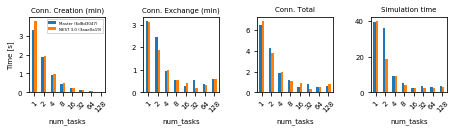

In [19]:
hpc_strong_m = pd.read_csv('results/hpc_benchmark_6d8d3047_daint_strong_scaling.csv')
hpc_strong_m['Case'] = ['Master (6d8d3047)'] * len(hpc_strong_m)
hpc_strong_3 = pd.read_csv('results/hpc_benchmark_3_0_daint_strong_scaling.csv')
hpc_strong_3['Case'] = ['NEST 3.0 (3aae0a19)'] * len(hpc_strong_3)

hpc_strong = pd.concat([hpc_strong_m, hpc_strong_3])

hpc_strong = calculate_T_conn_and_memory(hpc_strong)
values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total']
hpc_strong_p = plot_compare(hpc_strong, 'figures/hpc_benchmark_strong_scaling.pdf', values=values, index='num_tasks',
                            legend_loc='upper right')

hpc_strong_p

### Population model

Conn. Creation (min)                     Conn. Exchange (min)  \
Case         Master (6d8d3047) NEST 3.0 (3aae0a19)    Master (6d8d3047)   
num_tasks                                                                 
1                          NaN                 NaN                  NaN   
2                          NaN                 NaN                  NaN   
4                          NaN                 NaN                  NaN   
8                   118.997228           90.560710            58.489496   
16                   84.344661           54.816632            28.174133   
32                   66.665241           36.752460            14.249193   
64                   57.662544           27.547343             7.238075   
128                  38.256841           23.364649             4.629198   

                                    Conn. Total                      
Case      NEST 3.0 (3aae0a19) Master (6d8d3047) NEST 3.0 (3aae0a19)  
num_tasks                                                            
1                         NaN               NaN                 NaN  
2                         NaN               NaN                 NaN  
4                         NaN               NaN                 NaN  
8                   55.220412        178.294726          148.677884  
16                  26.375661        113.534168           82.126435  
32                  13.635903         81.843442           51.183455  
64                   6.981922         74.926960           35.009812  
128                  3.994257         64.025928           27.819271

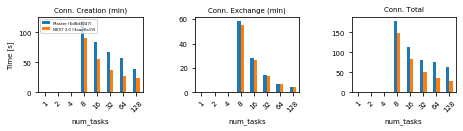

In [20]:
population_strong_m = pd.read_csv('results/population_model_6d8d3047_daint_strong_scaling_in.csv')
population_strong_m['Case'] = ['Master (6d8d3047)'] * len(population_strong_m)
population_strong_3 = pd.read_csv('results/population_model_3_0_daint_strong_scaling_in.csv')
population_strong_3['Case'] = ['NEST 3.0 (3aae0a19)'] * len(population_strong_3)

population_strong = pd.concat([population_strong_m, population_strong_3])

population_strong = calculate_T_conn_and_memory(population_strong)
values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total']
population_strong_p = plot_compare(population_strong, 'figures/population_model_strong_scaling.pdf', values=values,
                                   index='num_tasks', plot_T_sim=False, legend_loc='upper left')

population_strong_p

### Attemt to reproduce Jordan et. all (2018) appendix, fig. 4

Trenger en mindre scale

Conn. Creation (min)                     Conn. Exchange (min)  \
Case       Master (6d8d3047) NEST 3.0 (3aae0a19)    Master (6d8d3047)   
threads                                                                 
1                      50.40               54.76                36.70   
3                      30.81               31.98                26.41   
6                      22.64               23.88                21.35   
9                      16.59               17.95                18.61   
18                     12.10               14.02                15.62   
36                      9.08               11.99                16.70   

                                  Conn. Total                      \
Case    NEST 3.0 (3aae0a19) Master (6d8d3047) NEST 3.0 (3aae0a19)   
threads                                                             
1                     36.63             87.69               92.75   
3                     23.89             58.35               57.60   
6                     21.33             44.95               46.84   
9                     18.70             36.05               38.00   
18                    15.60             28.42               31.27   
36                    16.60             26.15               29.17   

          Simulation time                                T_nrns  \
Case    Master (6d8d3047) NEST 3.0 (3aae0a19) Master (6d8d3047)   
threads                                                           
1                  202.97              227.84              0.21   
3                  104.01              110.50              0.28   
6                   54.59               56.75              0.32   
9                   40.05               57.76              0.32   
18                  23.80               25.13              0.36   
36                  15.83               16.32              0.54   

                             
Case    NEST 3.0 (3aae0a19)  
threads                      
1                      0.14  
3                      0.40  
6                      0.39  
9                      0.20  
18                     0.37  
36                     0.43

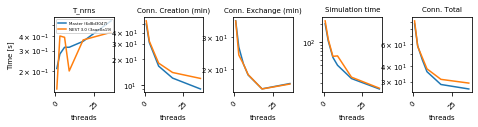

In [21]:
hpc_j_m = pd.read_csv('results/hpc_benchmark_6d8d3047_daint_strong_scaling_over_threads.csv')
hpc_j_m['Case'] = ['Master (6d8d3047)'] * len(hpc_j_m)
hpc_j_3 = pd.read_csv('results/hpc_benchmark_3_0_daint_strong_scaling_over_threads.csv')
hpc_j_3['Case'] = ['NEST 3.0 (3aae0a19)'] * len(hpc_j_3)

hpc_j = pd.concat([hpc_j_m, hpc_j_3])

hpc_j['VSize_nodes_sum'] = [None] * len(hpc_j)
hpc_j['VSize_ini_sum'] = [None] * len(hpc_j)
hpc_j = calculate_T_conn_and_memory(hpc_j)
hpc_j['threads'] = hpc_j['THREADS_PER_TASK']
values=['T_nrns', 'Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total']

hpc_j_p = plot_compare(hpc_j, 'figures/hpc_benchmark_strong_scaling_over_threads.pdf', index='threads',
                       values=values, legend_loc='upper left', plot_kind='line', logy=True)

hpc_j_p

## Compare versions

### num. nodes = 1,  num. threads = {1,3,6,9,18,36}, num. vps=36

Conn. Creation (min)                                   \
Case                    2.14    2.16   2.18 Master (6d8d3047)   
threads                                                         
1                      36.44   21.73  17.62             17.42   
3                      47.89   38.73  30.85             30.24   
6                      52.17   51.38  42.25             41.48   
9                      53.47   58.84  43.85             42.44   
18                     54.55   81.97  56.37             56.02   
36                     61.78  124.92  74.22             74.35   

                            Conn. Exchange (min)                \
Case    NEST 3.0 (3aae0a19)                 2.14   2.16   2.18   
threads                                                          
1                     18.83                 0.62  18.79  11.87   
3                     32.47                 0.89  29.74  24.27   
6                     43.56                 0.96  35.99  32.64   
9                     46.28                 0.91  50.30  48.41   
18                    71.54                 1.38  66.25  68.98   
36                   108.66                 1.44  91.19  77.44   

                                                      ...          \
Case    Master (6d8d3047) NEST 3.0 (3aae0a19)         ...           
threads                                               ...           
1                   11.69               11.67         ...           
3                   24.48               23.32         ...           
6                   32.80               31.83         ...           
9                   45.36               45.06         ...           
18                  68.54               73.30         ...           
36                  77.49               77.72         ...           

        Memory per VP                                        \
Case             2.14      2.16      2.18 Master (6d8d3047)   
threads                                                       
1            2.312773  5.072531  3.096897          3.097431   
3            2.028328  4.422857  2.269574          2.295633   
6            1.983972  4.332034  2.121685          2.118519   
9            1.973401  4.311907  2.100494          2.067026   
18           1.963256  4.293865  2.008091          1.997216   
36           1.968212  4.284930  1.989075          1.989090   

                            Simulation time                                    \
Case    NEST 3.0 (3aae0a19)            2.14    2.16    2.18 Master (6d8d3047)   
threads                                                                         
1                  3.097244           85.58   87.81   92.16             89.93   
3                  2.308753          121.11  128.25  126.82            123.51   
6                  2.073484          128.85  131.90  134.71            133.43   
9                  2.098363          124.27  135.43  136.02            129.22   
18                 2.016601          130.37  137.20  137.85            135.70   
36                 2.018070          173.78  187.95  204.53            203.74   

                             
Case    NEST 3.0 (3aae0a19)  
threads                      
1                     98.86  
3                    131.22  
6                    137.56  
9                    135.80  
18                   139.79  
36                   210.48  

[6 rows x 25 columns]

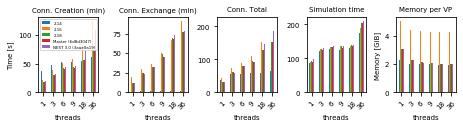

In [22]:
hpc_214 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_214_daint_threads_SCALE15.csv')
hpc_214['Case'] = ['2.14']*len(hpc_214)
hpc_216 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_216_daint_threads_SCALE15.csv')
hpc_216['Case'] = ['2.16']*len(hpc_216)
hpc_218 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_218_daint_threads_SCALE15.csv')
hpc_218['Case'] = ['2.18']*len(hpc_218)
hpc_m   = pd.read_csv('results/hpc_benchmark_6d8d3047_daint_threads_s15.csv')
hpc_m['Case']   = ['Master (6d8d3047)']*len(hpc_m)
hpc_3   = pd.read_csv('results/hpc_benchmark_3_0_daint_threads_s15.csv')
hpc_3['Case']   = ['NEST 3.0 (3aae0a19)']*len(hpc_3)

hpc_versions = pd.concat([hpc_214, hpc_216, hpc_218, hpc_m, hpc_3])

hpc_versions = calculate_T_conn_and_memory(hpc_versions)
hpc_versions['threads'] = hpc_versions['THREADS_PER_TASK']
hpc_versions_p = plot_compare(hpc_versions, 'figures/hpc_different_versions.pdf', index='threads',
                              plot_T_sim=True, legend_loc='upper left',
                              rot=45)
hpc_versions_p

### num. threads = 1, num. nodes = {1, 2, 4, 8, 16, 32}, num. vps = 36

Conn. Creation (min)                                                      \
Case                 2.14   2.16   2.18 Master (6d8d3047) NEST 3.0 (3aae0a19)   
N_VP                                                                            
36                  35.65  21.84  17.56             17.53               18.82   
72                  37.68  21.74  17.36             17.18               19.03   
144                 39.38  21.71  17.38             17.33               18.97   
288                 40.99  22.01  17.39             17.20               19.15   
576                 42.90  21.77  17.39             17.23               19.44   
1152                43.87  21.73  17.37             17.12               20.17   

     Conn. Exchange (min)                                                      \
Case                 2.14   2.16   2.18 Master (6d8d3047) NEST 3.0 (3aae0a19)   
N_VP                                                                            
36                   0.60  18.22  11.78             11.96               11.71   
72                   0.63  18.84  11.78             11.91               12.04   
144                  0.58  22.50  12.36             12.13               12.12   
288                  0.67  22.05  13.03             13.41               13.53   
576                  0.90  24.56  15.09             15.27               15.39   
1152                 1.28  29.25  19.17             20.06               18.79   

             ...         Memory per VP                                        \
Case         ...                  2.14      2.16      2.18 Master (6d8d3047)   
N_VP         ...                                                               
36           ...              2.312611  5.072531  3.096897          3.097431   
72           ...              2.327074  5.073708  3.107514          3.108052   
144          ...              2.707514  5.075892  3.109698          3.110236   
288          ...              3.149024  5.080248  3.114054          3.114592   
576          ...              3.144015  5.108859  3.578192          3.578964   
1152         ...              3.161597  5.123802  4.092529          4.091714   

                         Simulation time                                    \
Case NEST 3.0 (3aae0a19)            2.14    2.16    2.18 Master (6d8d3047)   
N_VP                                                                         
36              3.097243           82.85   88.38   90.13             90.82   
72              3.107861           84.19   87.63   90.85             90.70   
144             3.110045           87.78   92.08   95.31             95.48   
288             3.114401           97.88  105.33  105.49            106.74   
576             3.577908          110.44  119.03  128.16            129.06   
1152            4.098217          140.54  163.31  172.90            176.92   

                          
Case NEST 3.0 (3aae0a19)  
N_VP                      
36                 97.74  
72                 97.94  
144               102.74  
288               114.11  
576               137.00  
1152              234.30  

[6 rows x 25 columns]

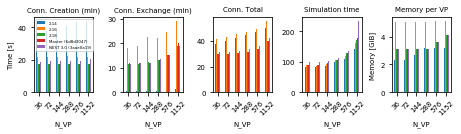

In [23]:
hpc_214_t1 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_214_daint_n1_SCALE15.csv')
hpc_214_t1['Case'] = ['2.14']*len(hpc_214_t1)
hpc_216_t1 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_216_daint_n1_SCALE15.csv')
hpc_216_t1['Case'] = ['2.16']*len(hpc_216_t1)
hpc_218_t1 = pd.read_csv('../benchmark_plots/benchmark_results/hpc_benchmark_218_daint_n1_SCALE15.csv')
hpc_218_t1['Case'] = ['2.18']*len(hpc_218_t1)
hpc_m_t1   = pd.read_csv('results/hpc_benchmark_6d8d3047_daint_t1_s15.csv')
hpc_m_t1['Case']   = ['Master (6d8d3047)']*len(hpc_m_t1)
hpc_3_t1   = pd.read_csv('results/hpc_benchmark_3_0_daint_t1_s15.csv')
hpc_3_t1['Case']   = ['NEST 3.0 (3aae0a19)']*len(hpc_3_t1)

hpc_versions_t1 = pd.concat([hpc_214_t1, hpc_216_t1, hpc_218_t1, hpc_m_t1, hpc_3_t1])

hpc_versions_t1 = calculate_T_conn_and_memory(hpc_versions_t1)
hpc_versions_t1_p = plot_compare(hpc_versions_t1, 'figures/hpc_different_versions_t1.pdf', legend_loc='upper left',
                                 rot=45)

hpc_versions_t1_p